In [35]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, os
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../trans_simulation/')) # include path with simulation specifications
import style; reload(style)
# Close other plots by adding 'c' after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
picture_format = '.pdf'
######################################################
# Import specific moduls
import network_params; reload(network_params)
import user_params as user; reload(user)
%matplotlib inline

xfactor = 2
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True


def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def print_perc(i, i_total):
    i_perc = round(100 * i / i_total)
    print("%i"%(i_perc), end="\r")

In [3]:
# Get data
data_path = user.data_dir
sim_spec = user.simulation_spec
print(sim_spec)

file_name  = sim_spec + ".hdf5"  
data_file = h5py.File(os.path.join(data_path, file_name), "r")

#area    = data_file.attrs["area"]   
#t_sim   = data_file.attrs["t_sim"]  
#dt      = data_file.attrs["dt"]    
#populations   = data_file.attrs["populations"] 
#layers        = data_file.attrs["layers"]        
#types         = data_file.attrs["types"]     
#n_populations = data_file.attrs["n_populations"]
#n_layers      = data_file.attrs["n_layers"]       
#n_types       = data_file.attrs["n_types"] 

net = network_params.net()
area = net.area
populations     = net.populations 
layers          = net.layers 
types            = net.types 
n_populations   = net.n_populations 
n_layers         = net.n_layers 
n_types          = net.n_types 

t_sim = 1.2   # s
t_trans = 0.2 # s
t_measure = t_sim - t_trans

# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]

# Mean and Std of firing rates and CV of ISI
rates_mean  = np.zeros(n_populations)
rates_std   = np.zeros(n_populations)
cv_isi_mean = np.zeros(n_populations)
cv_isi_std  = np.zeros(n_populations)
no_isi = []

In [21]:
# Analyze spikes
sim_spec2 = "d0.00_j1.00_sdJ0.00"
grp = data_file[sim_spec2 + "/spikes"]
dt = grp.attrs["dt"]
neuron_ids_all = []
times_all = []
for i, population in enumerate(populations):
    neuron_ids_all.append([])
    times_all.append([])
    # Get data
    subgrp = grp[population]
    raw_times_all   = subgrp["times"][:] * dt
    rec_neuron_i    = subgrp["rec_neuron_i"][:]
    

    # Firing rate:
    n_spikes = np.diff(rec_neuron_i)
    rates = n_spikes / t_measure # Hz
    
    cv_isi_all = np.empty(0)
    indices = rec_neuron_i - rec_neuron_i[0]
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]

        if n_spikes[j] > 1:
            isi = np.diff(times)
            mean_isi = np.mean(isi)
            var_isi = np.var(isi)
            cv_isi = var_isi / mean_isi**2
            cv_isi_all = np.append(cv_isi_all, cv_isi)
        else:
            no_isi.append(population + '_' + str(j))
        
        times_all[i].append(times*1e-3)
        neuron_ids_all[i].append([rec_neuron_i[j]]*n_spikes[j])

    # Means
    rates_mean[i] = np.mean(rates)
    rates_std[i] = np.std(rates)
    cv_isi_mean[i] = np.mean(cv_isi_all)
    cv_isi_std[i] = np.std(cv_isi_all)

L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e


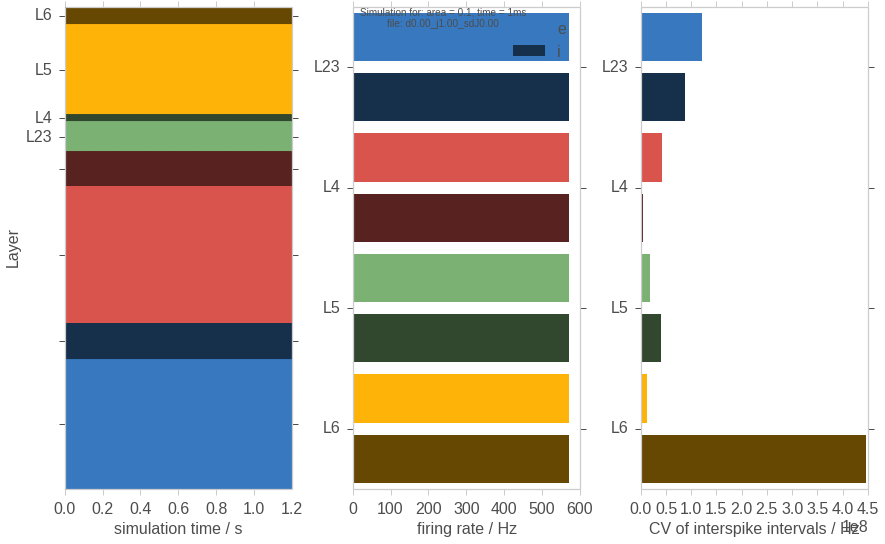

In [38]:
fig = plt.figure()
suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
suptitle += '\nfile: ' + sim_spec2

fig.suptitle(suptitle, y=0.98)
# Raster plot
ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
# Rates
ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
# CV of interspike interval (ISI)
ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)

y_mean = np.arange(n_populations) + 0.1
bar_height = 0.8 
for i, population in enumerate(populations):
    print(population)
    for times, neuron_ids in zip(times_all[i], neuron_ids_all[i]):
        ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
    ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)

ylim_mean = (0, n_populations)
yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)

# Raster Plot
xlim = (0, t_sim)
ymax_raster = max(neuron_ids_all[0][-1][-1], neuron_ids_all[-1][-1][-1])
ylim = (0, ymax_raster)
# set yticks to center of recorded n spikes of one layer
yticks = [(neuron_ids[-1][0] + neuron_ids[0][0]) * 0.5 for neuron_ids in neuron_ids_all]
ax0.set_yticks(yticks)
ax0.set_yticklabels(layers)
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Layer')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.grid(False)

# Rates
ax1.set_yticks(yticks_mean)
ax1.set_yticklabels(layers)
ax1.set_xlabel('firing rate / Hz')
#ax1.set_ylabel('Layer')
ax1.set_ylim(*ylim_mean)
#ax1.set_xlim(0, 20)
ax1.grid(False)
  
# CV of ISI
ax2.set_yticks(yticks_mean)
ax2.set_yticklabels(layers)
ax2.set_xlabel('CV of interspike intervals / Hz')
#ax2.set_ylabel('Layer')
ax2.set_ylim(*ylim_mean)
#ax2.set_xlim(0, 20)
ax2.grid(False)

# Legend; order is reversed, such that labels appear correctly
for i in range(n_types):
    ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
ax1.legend(loc='best')

for ax in fig.axes:
    style.fixticks(ax)
fig_name = 'rates_etc'

#fig.savefig(figure_path + fig_name + picture_format)

In [5]:
# Clear large varibales:
times_all = None
neurons_ids_all= None

# Membrane potentials

In [6]:
"""Analysis of membrane potential distribution."""
V_times_file    = 'V_times.npy'
V_times         = np.load(npy_path + V_times_file)

n_bins_Vs   = 200
V_min = -100
V_max = -50
V_step = (V_max - V_min) / n_bins_Vs
bin_edges = np.linspace(V_min, V_max, n_bins_Vs + 1)
n_hist          = 10
histo_means     = np.zeros((n_populations, n_bins_Vs))
Vs_plot         = np.zeros((n_populations, V_times.shape[0], n_hist))
for i, population in enumerate(populations):
    print(population)
    # Get membrane potentials
    volts_file  = 'voltages_' + population + '.npy'
    Vs_all      = np.load(npy_path + volts_file)
    
    histo_means[i], b_e  = np.histogram(Vs_all, bin_edges, normed=True)

    Vs_plot[i] = Vs_all[:n_hist].T

L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e


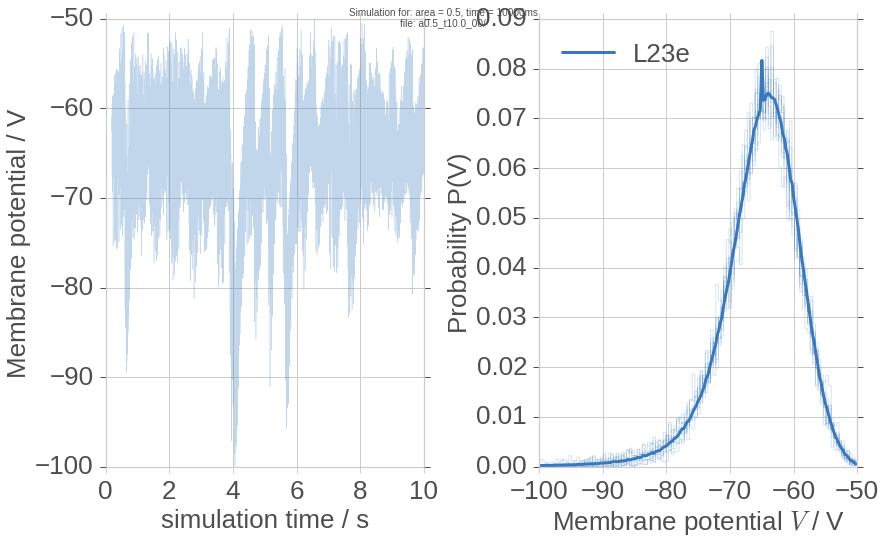

In [7]:
fig = plt.figure()
suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
suptitle += '\nfile: ' + simulation_spec
if sli: 
    suptitle += '  SLI'
fig.suptitle(suptitle, y=0.98)
# Membrane pot over time
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

for i, population in enumerate(populations):
    if i == 7:
        j = 0
        Vs = Vs_plot[i].T[j]
        ax0.plot(V_times*1e-3, Vs, 
            '-', color=colors[i], alpha=0.3, linewidth=0.5, label=population)
        ax1.plot(bin_edges[:-1], histo_means[i], linewidth=3., color=colors[i], label=population)
        ax1.hist(Vs_plot[i], bins=n_bins_Vs, normed=True, histtype='step', 
            fill=False, linewidth=1.0, color=[colors[i]]*n_hist, alpha=0.2)
    
# Potential over time
xlim = (0, t_sim * 1e-3)
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Membrane potential / V')
ax0.set_xlim(*xlim)
ax0.grid(True)

for ax in fig.axes[1:]:
    ax.set_ylabel('Probability P(V)')
    ax.set_xlabel('Membrane potential $V$ / V')
    ax.set_xlim(V_min, V_max)
    ax.grid(True)
    ax.legend(loc='best')

for ax in fig.axes:
    style.fixticks(ax)
fig_name = 'potential'
if sli:
    fig_name += '_sli'
#fig.savefig(figure_path + fig_name + picture_format)

In [8]:
"""
Class for mean field approximation of microcircuit model. 
Contains parameters and functions of stationary frequency v.
"""

######################################################
# Main class
######################################################
class mf_net:
    def __init__(self, n_layer=4):
        '''Initialize according to the model chosen
        '''
        n_types = 2
        n_pop   = n_layer * n_types

        ######################################################
        # Microcircuit model parameters
        ######################################################
        self.populations = np.array(net.populations)[:n_pop]
        # Neuron model
        # Reset voltage and threshold (set V_r to zero)
        V_reset, V_th= [net.model_params[key] for key in ('V_reset', 'V_th')]
        self.E_L    = net.model_params['E_L']
        self.V_r    = V_reset - self.E_L
        self.theta  = V_th - self.E_L
        # All times should be in seconds!
        self.t_ref  = net.model_params['t_ref'] * 1e-3
        self.tau_m  = net.model_params['tau_m'] * 1e-3
        # Weights
        self.J_ab   = net.PSPs[:n_pop, :n_pop]
        self.J_ext  = net.PSP_ext
        # Synapse numbers
        n_neurons   = net.full_scale_n_neurons
        K_ab        = np.log(1. - net.conn_probs) / np.log(1. - 1. / np.outer(n_neurons, n_neurons))
        self.C_ab   = (K_ab / n_neurons)[:n_pop, :n_pop]
        self.C_aext = net.K_bg[:n_pop]
        # Background rate
        self.v_ext  = net.bg_rate

        ######################################################
        # Predefine matrices
        ######################################################
        self.mu_ext = self.J_ext * self.C_aext * self.v_ext
        self.var_ext = self.J_ext ** 2 * self.C_aext * self.v_ext
        self.mat1 = self.C_ab * self.J_ab
        self.mat2 = self.C_ab * self.J_ab ** 2
        self.jac_mat1 = np.pi * self.tau_m**2 * self.mat1.T
        self.jac_mat2 = np.pi * self.tau_m**2 * 0.5 * self.mat2.T


    ######################################################
    # Methods
    ######################################################
    # Mean and std_dev of synaptic currents of one neuron
    def mu(self, v):
        return self.tau_m * (np.dot(self.mat1, v) + self.mu_ext)
        
    def sd(self, v):
        return np.sqrt(self.tau_m * (np.dot(self.mat2, v) + self.var_ext))
    
    # Membrane potential probability distribution P(V)
    def prob_V(self, V_array, mu, sd, v):
        from scipy.integrate import quad
        step        = lambda x: 0.5 * (np.sign(x) + 1)
        P_integrand = lambda u: step(u - self.V_r) * np.exp(u**2)
        
        low = (self.V_r - mu) / sd
        up  = (self.theta - mu) / sd
        integral    = quad(P_integrand, low, up)[0]
        
        P_V_array = 2 * v * self.tau_m / sd * np.exp(- ((V_array - self.E_L) - mu)**2 / sd**2) * integral
        return step(-(V_array - self.E_L) + self.theta) * P_V_array
    
    # Self consistency equation
    def integrand(self, u):
        from scipy.special import erf
        return np.exp(u**2) * (1. + erf(u))
    
    def summand1(self, v):
        return (-1. / v + self.t_ref) / (self.tau_m * np.pi)

    def root_v0(self, v):
        """The integral equations to be solved
        Returns the array 'root', each entry corresponding to one population.
        Solve for root == 0.
        """
        from scipy.integrate import quad
        mu_v  = self.mu(v)
        sd_v  = self.sd(v)
        low = (self.V_r - mu_v) / sd_v
        up  = (self.theta - mu_v) / sd_v
        bounds      = np.array([low, up]).T
        integral    = np.array([quad(self.integrand, lower, upper)[0] for lower, upper in bounds])
        root        = - 1. / v + self.t_ref + np.pi * self.tau_m * integral
        return root

######################################################

Popul.	rate  	reduced fit	full fit        	Brunel's for v0
      	[  v0]	[ mu0  sd0]	[  v1  mu1  sd1]	[ mu_b  sd_b]
L6i	[8.24]	[7.92 4.98]	[8.62 7.93 5.04]	[-34.41 9.12]
L6e	[1.12]	[1.93 6.20]	[2.24 2.04 6.76]	[14.29 4.23]
L5i	[9.01]	[7.54 5.40]	[8.94 7.54 5.38]	[-109.20 10.10]
L5e	[8.23]	[5.92 6.33]	[6.95 5.86 6.10]	[-10.21 5.82]
L4i	[6.13]	[5.63 6.05]	[6.51 5.65 6.13]	[-27.56 6.72]
L4e	[4.59]	[5.71 5.63]	[6.34 5.78 6.00]	[13.14 3.25]
L23i	[3.29]	[5.82 5.18]	[4.42 5.87 5.45]	[10.08 5.77]
L23e	[1.00]	[0.58 6.76]	[2.13 0.68 7.44]	[24.95 2.52]


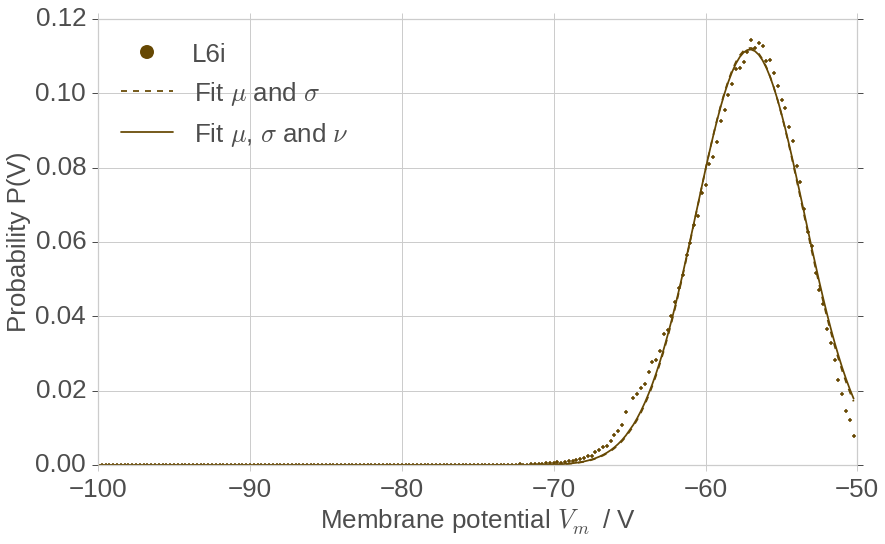

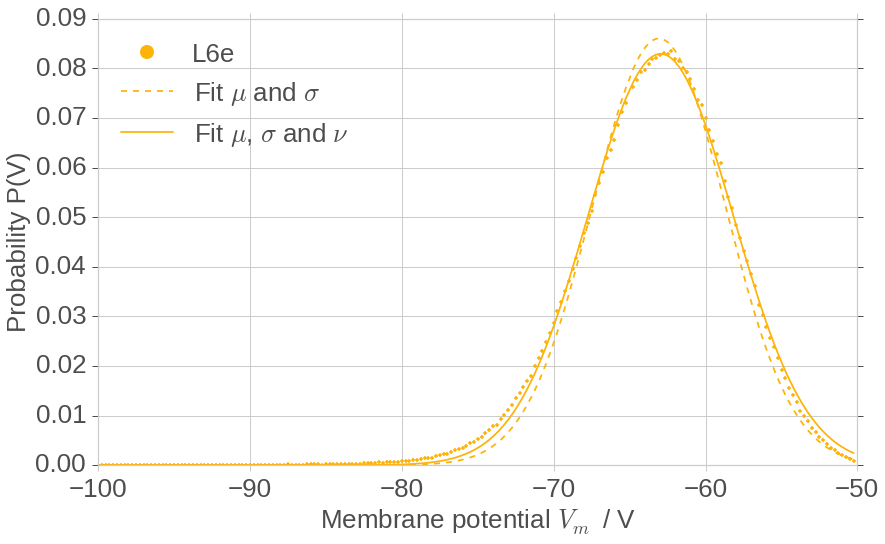

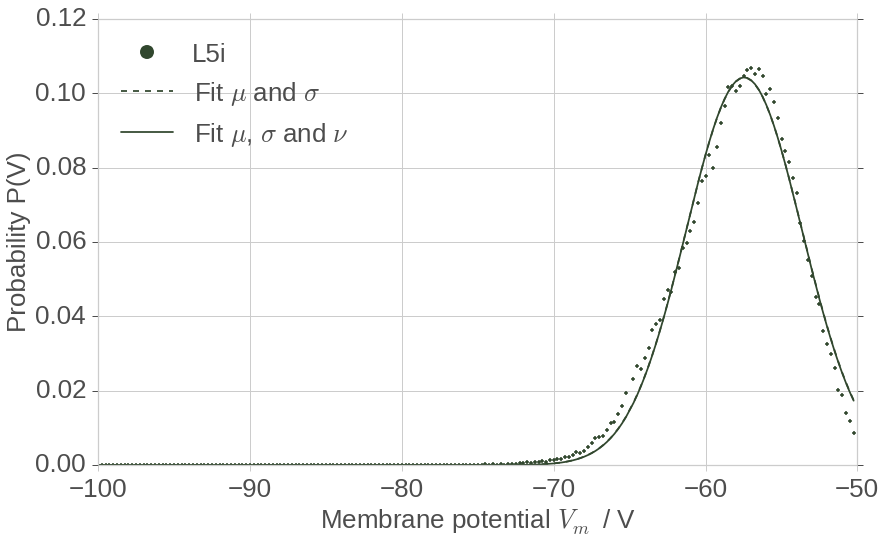

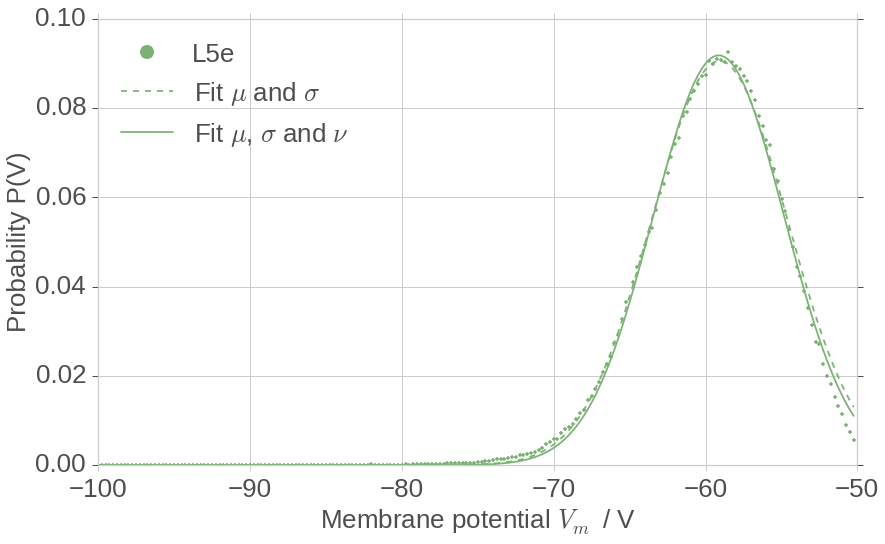

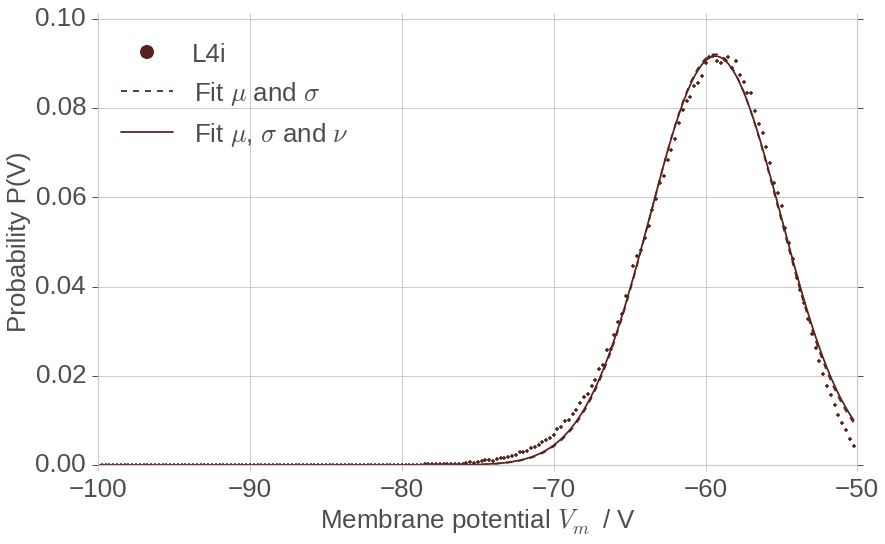

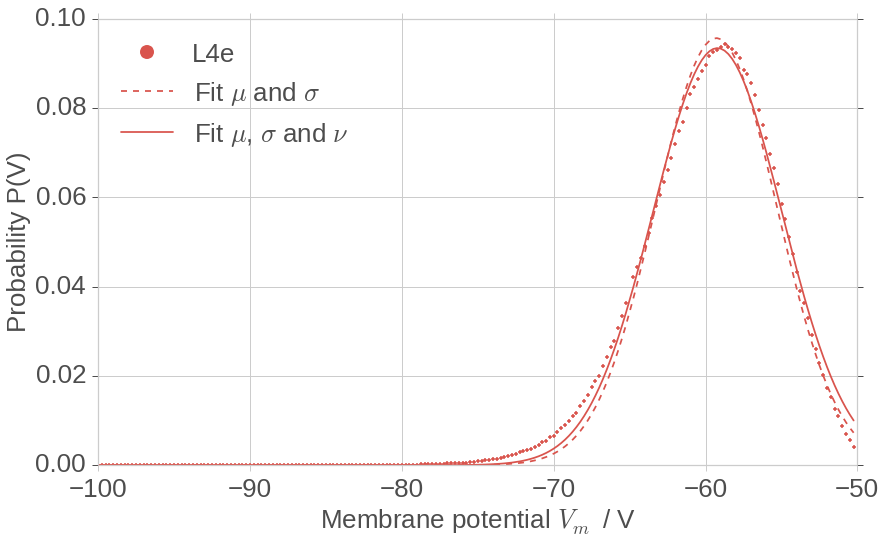

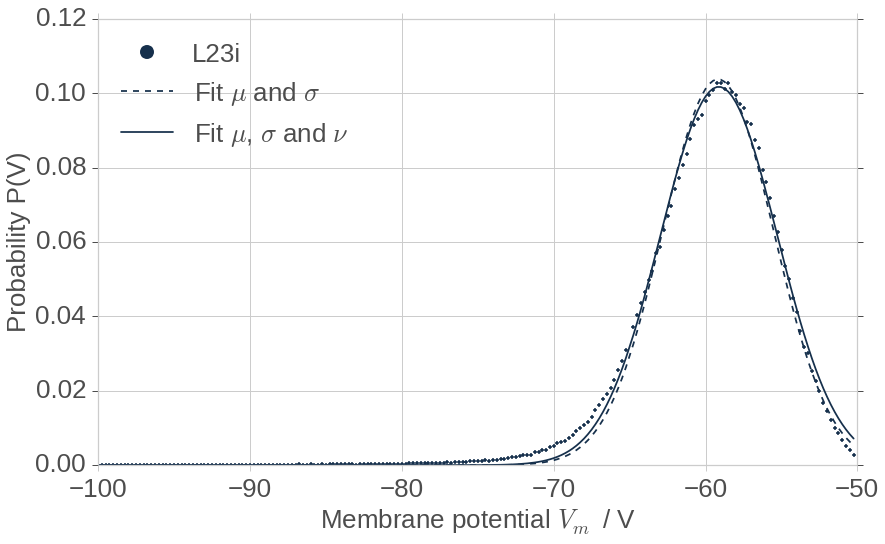

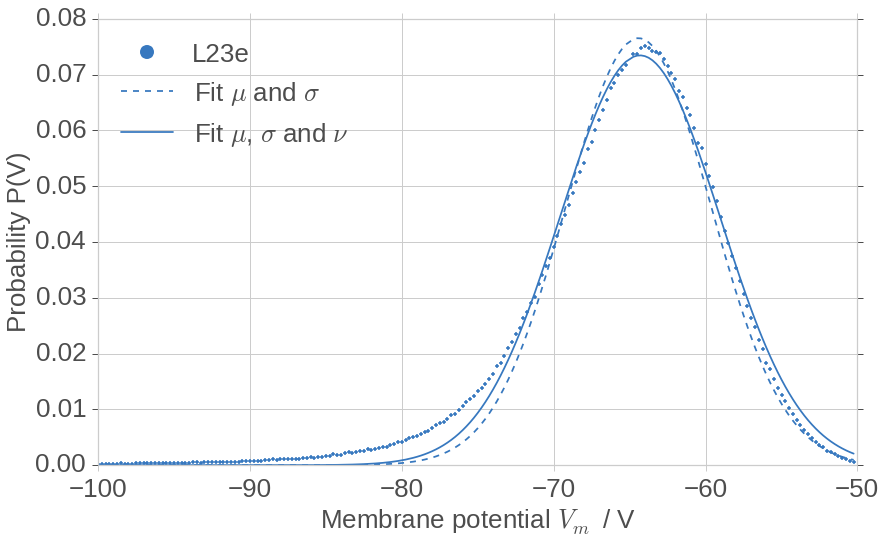

In [9]:
from scipy.optimize import curve_fit
model = mf_net()

v0  = rates_mean # Hz
mu_brunel = model.mu(v0)
sd_brunel = model.sd(v0)

V_array_full = bin_edges[:-1]
V_r_arg = np.argmin(np.abs(V_array_full - (model.V_r + model.E_L)))
V_array = np.delete(V_array_full, V_r_arg)

print("Popul.\trate  \treduced fit\tfull fit        \tBrunel's for v0")
print("      \t[  v0]\t[ mu0  sd0]\t[  v1  mu1  sd1]\t[ mu_b  sd_b]")
for i, population in enumerate(populations):
    P_V_data = np.delete(histo_means[i], V_r_arg) # Remove outlier due to V_r

    # Initial guess
    mu0 = 1 # V
    sd0 = 9 # V
    V_guess = model.prob_V(V_array, mu0, sd0, v=v0[i])

    # Fit only mu and sd
    func = lambda V, mu, sd: model.prob_V(V, mu, sd, v=v0[i])
    p0 = (1, 9)
    popt, pcov = curve_fit(func, V_array, P_V_data, p0=p0)
    V_opt = func(V_array, *popt)

    # Fit v, mu, sd
    func_v = lambda V, mu, sd, v: model.prob_V(V, mu, sd, v)
    p0 = (mu0, sd0, v0[i])
    popt_v, pcov_v = curve_fit(func_v, V_array, P_V_data, p0=p0)
    V_opt_v = func_v(V_array, *popt_v)
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    V_theo = model.prob_V(V_array, mu_brunel[i], sd_brunel[i], v0[i])

    # Plotting
    fig = plt.figure()
    ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

    ax1.plot(V_array, P_V_data, ".", color=colors[i], label=population)
    #ax1.plot(V_array, V_guess, color=colors[i], label=population)
    ax1.plot(V_array, V_opt, "--", color=colors[i], label="Fit $\mu$ and $\sigma$")
    ax1.plot(V_array, V_opt_v, "-", color=colors[i], label="Fit $\mu$, $\sigma$ and $\\nu$")
    #ax1.plot(V_array, V_theo, "-.", color=colors[i], label=population)

    ax1.set_ylabel('Probability P(V)')
    ax1.set_xlabel('Membrane potential $V_m$ / V')
    ax1.set_xlim(V_min, V_max)
    ax1.grid(True)
    ax1.legend(loc='best')
    for ax in fig.axes:
        style.fixticks(ax)
        
        
    # Printing
    results_str = "[%.2f]\t[%.2f %.2f]\t[%.2f %.2f %.2f]\t[%.2f %.2f]"%(v0[i], 
                                                                popt[0], popt[1], 
                                                                popt_v[2], popt_v[0], popt_v[1], 
                                                                mu_brunel[i], sd_brunel[i])
    print(population + "\t" + results_str)